In [1]:
%pip -q install -U langchain_experimental langchain_core
%pip -q install -U google-generativeai
%pip -q install -U google-ai-generativelanguage==0.4.0
%pip -q install -U langchain-google-genai
%pip -q install chromadb
# %pip -q install -U langgraph langsmith
%pip install -U --quiet langgraph langsmith langchain_openai
%pip install pillow
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from getpass import getpass
import google.generativeai as genai


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("LANGCHAIN_API_KEY")
_getpass("GOOGLE_API_KEY")
_getpass("OPENAI_API_KEY")
_getpass("GCP_PROJECT_ID")

# os.environ["GOOGLE_API_KEY"] = userdata.get('google_ai_studio')

# import os

# os.environ["GOOGLE_API_KEY"] = userdata.get('google_ai_studio')

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"

genai.configure(api_key = os.environ["GOOGLE_API_KEY"])

C:\Users\cfran\anaconda3\envs\python3.10.12\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LANGCHAIN_API_KEY= ········
GOOGLE_API_KEY= ········
OPENAI_API_KEY= ········
GCP_PROJECT_ID= ········


In [3]:
# %pip -q install -U  playwright > /dev/null
%pip install --user pytest-playwright
# !pip -q install -U  playwright
%pip install -U langchainhub
!playwright install

Note: you may need to restart the kernel to use updated packages.



'playwright' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Graph State
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from playwright.async_api import Page

# State of the BBox aka the window the playwright will look through.
class BBox(TypedDict):
  x: float
  y: float
  text: str
  type: str
  arialLabel: str

class Prediction(TypedDict):
  action: str
  args: Optional[List[str]]

# The agent's state while it runs.
class AgentState(TypedDict):
  page: Page # Playwright's webpage to interact with web environment.
  input: str # User request.
  img: str  # Screenshot encoded in b64.
  bboxes: List[BBox] # List of bounding boxes from browser annotation function.
  prediction: Prediction # Agent's Predictions.
  scratchpad: List[BaseMessage] # Agent's intermediate steps.
  observation: str # Latest response from a tool.

In [152]:
# Agent Tools
  # Click
  # Type
  # Scroll
  # Wait
  # Go back
  # Return to search engine

# To perform async functions.
import asyncio
# To find the OS you're working with.
import platform

# Will click (x,y) corrodinate in a bounding box.
async def click(state: AgentState):
  # Get page and click_args
  page = state["page"]
  click_args = state["prediction"]["args"]

  # Check if click_args exists.
  if click_args is None or len(click_args) != 1:
    return f"Failed to click bouding box labeled as number {click_args}"

  # Get the bbox via its id from click_args
  bbox_id = click_args[0]
  bbox_id = int(bbox_id)
  try:
    bbox = state["bboxes"][bbox_id]
  except:
    return f"Error: no bbox for : {bbox_id}"

  # Retrieve bounding box's coordinates and click there.
  x, y = bbox["x"], bbox["y"]
  res = await page.mouse.click(x,y)

  # Return confirmation of click.
  return f"Clicked {bbox_id}"

async def type_text(state: AgentState):
  # Get page and type_args
  page = state["page"]
  type_args = state["prediction"]["args"]

  # Check if type_args exists.
  if type_args is None or len(type_args) != 2:
    return (
      f"Failed to type in element from bounding box labeled as number {type_args}"
      )

  # With type_args retrieve bounding box's coordinates, and content to type.
  bbox_id = type_args[0]
  bbox_id = int(bbox_id)
  bbox = state["bboxes"][bbox_id]
  x, y = bbox["x"], bbox["y"]
  text_content = type_args[1]

  # Select Bounding box via clicking.
  await page.mouse.click(x,y)
  # Use platform to identify system and choose corresponding keys to select all.
  select_all = "Meta_A" if platform.system() == "Darwin" else "Control+A"
  # Select all content in the bounding box.
  await page.keyboard.press(select_all)
  # Clear text box.
  await page.keyboard.press("Backspace")
  # Type in and enter content.
  await page.keyboard.type(text_content)
  await page.keyboard.press("Enter")
  # Return confirmation of typing.
  return f"Typed {text_content} and submitted."


# Futher commenting needed.
async def scroll(state: AgentState):
  # Get page and scroll_args.
  page = state["page"]
  scroll_args = state["prediction"]["args"]

  # Check if scroll_args exists.
  if scroll_args is None or len(scroll_args) != 2:
    return "Failed to scroll due to incorrect arguements."

  # Retrieve target and direction from scroll_args.
  target, direction = scroll_args

  if target.upper() == "WINDOW":
    scroll_amount = 500
    scroll_direction = (
        -scroll_amount if direction.lower() == "up" else scroll_amount
    )
    await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
  else:
    scroll_amount = 200
    target_id = int(target)
    bbox = state["bboxes"][target_id]
    x, y = bbox["x"], bbox["y"]
    scroll_direction =  (
            -scroll_amount if direction.lower() == "up" else scroll_amount
    )
    await page.mouse.move(x,y)
    await page.mouse.wheel(0, scroll_direction)

  return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"

async def wait(state: AgentState):
  sleep_time = 5
  await asyncio.sleep(sleep_time)
  return f"Waited for {sleep_time}s."

async def go_back(state: AgentState):
  page = state["page"]
  await page.go_back()
  return f"Naviaged bact to a page to {page.url}."

async def to_google(state: AgentState):
  page = state["page"]
  await page.goto("https://ww.google.com/")
  return "Navigated to google.com."

In [153]:
"""
Define Agent with a mulitmodal model to decide action for each step
1. A function to markup the page with bounding boxes.
2. Prompt to hold user input, annoted images, and agent scratchpad.
3. Gemini Pro to decide the next steps.
4. Parsing logic to extract the action.
"""

import asyncio
import base64

from langchain_core.runnables import chain as chain_decorator
# mark_page.js will create bounding boxes in the screenshot for the
# model to find, and returns list of those bounding boxes.
with open('./mark_page.js') as f:
  mark_page_script = f.read()
"""
This Chain will take AgentState's page and place bounding boxes its elements.
The newly edited page will be screeenshotted and encoded into base-64, and its
bounding boxes counted into a list of BBox Objects. Both are placed stored in 
dictionary under the keys "img" and "bboxes" respectively.
"""
@chain_decorator
async def mark_page(page):
  await page.evaluate(mark_page_script)
  # Place the bounding boxes and get list of them by running markPage().
  for _ in range(10):
    try:
    # Create bounding boxes on the page for the model to find
    # and return the list of those bounding boxes.
      bboxes = await page.evaluate("markPage()")
      break
    except:
      asyncio.sleep(3)
  # Take a screenshot to be saved for Agent's input.
  screenshot = await page.screenshot()
  # Remove bounding boxes as to not pollute the screenshot
  # for the next action.
  await page.evaluate("unmarkPage()")
  # Return the image previously base64_encoded, and the bounding boxes.
  return {
      "img" : base64.b64encode(screenshot).decode(),
      "bboxes" : bboxes,
  }

In [154]:
"""
  Agent Definition.
"""

from langchain import hub
from langchain_core.output_parsers  import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

"""
Add the image and bboxes gathered from the page to the AgentState.
"""

async def annotate(state):
  # Retrieve the markedup screenshot of the page and the list of its Bounding Boxes.
  marked_page = await mark_page.with_retry().ainvoke(state["page"])
  return {**state, **marked_page}

"""
  Given the state, create a string that is a numbered list of descriptions of each bounding box
  containing the element-type and the text. This will be placed in the AgentState under the 
  "bbox_descriptions".
"""
def format_descriptions(state):
  labels = []
  # Create a lable from each bounding boxes' count, elemnent type, and text.
  for i, bbox in enumerate(state["bboxes"]):
    text = bbox.get("ariaLabel") or ""
    if not text.strip():
      text = bbox["text"]
    el_type = bbox.get("type")
    # Append these labels in a list.
    labels.append(f'{i} (<{el_type}/>): "{text}"')
  # Concatenate the labels in string in format to make numbered list.
  bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
  # Add string to the state with the key "bbox_descriptions" and return the
  # state.
  return {**state, "bbox_descriptions": bbox_descriptions}
"""
Retrieve the Action and its inputs from the given text.
"""
def parse(text: str) -> dict:
  # The text consists of action blocks with the prefix "Action: ".
  # The text must start with the prefix "Action: " else retry.
  action_prefix = "Action: "
  if not text.strip().split("\n")[-1].startswith(action_prefix):
    return {"action": " retry", "args":f"Could not parse LLM Output: {text}"}

  # After the text's action_prefix are the action blocks seperated by
  # newline characters, get latest action block.
  action_block = text.strip().split("\n")[-1]
  # Ex. 'Action: Type 8; WebVoyager: could you explain the paper (on arxiv)?"'

  # Slice the prefix from the action block, and separate block by
  # spaces. Ex.
  #            'Type [8]; WebVoyager: could you explain the paper (on arxiv)?"'
  action_str = action_block[len(action_prefix) :]
  split_output = action_str.strip("- ").strip("-").split(" ", 1)
  #            ['Type', '[8]; WebVoyager: could you explain the paper (on arxiv)?"']
    
  # There will be at least one string, the action, 2nd string, action_input.
  if len(split_output) == 1:
    action, action_input = split_output[0], None
  else:
    action, action_input = split_output
  # Remove all leading and trailing spaces of action string.
  action = action.strip("-").strip()
  # Repeat for the existing action_input, separate action_input by ';' into list of arguements
  # and remove leading/trailing spaces and square brackets.
  # "Action: Type [8]; WebVoyager: could you explain the paper (on arxiv)?" -> 
  #                     {"action": Type, "args" : ["8", "WebVoyager: could you explain the paper (on arxiv)?"]}
  # "Action: Click [1]" -> {"action": Click, "args" : ["1"]}
  if action_input is not None:
    action_input = [
        inp.strip("-").strip().strip("[]") for inp in action_input.strip().split(";")
    ]
  return {"action": action, "args": action_input}

prompt = hub.pull("wfh/web-voyager")

In [155]:
action_prefix = "Action: "
action_block = "Action: -Type 7; Could you explain the WebVoyager paper (on arxiv)?"
action_str = action_block[len(action_prefix) :]
print(action_str.strip("- ").strip("-"))
split_output = action_str.strip("- ").strip("-").split(" ", 1)
print(action_str)
if len(split_output) == 1:
    action, action_input = split_output[0], None
else:
  action, action_input = split_output
  # Remove all leading and trailing spaces of action string.
  action = action.strip().strip("-")
  # Repeat for the existing action_input, separate action_input by ';' into list of arguements
  # and remove leading/trailing spaces and square brackets.
  # "Action: Type [8]; WebVoyager: could you explain the paper (on arxiv)?" -> 
  #                     {"action": Type, "args" : ["8", "WebVoyager: could you explain the paper (on arxiv)?"]}
  # "Action: Click [1]" -> {"action": Click, "args" : ["1"]}
print("action: ",action)
print("args: ", action_input)
if action_input is not None:
    action_input = [
        inp.strip().strip("[]") for inp in action_input.strip().split(";")
    ]
print(f"Action: {action}, args: {action_input}")
# action = action.strip("-").strip()
# print(action)

Type 7; Could you explain the WebVoyager paper (on arxiv)?
-Type 7; Could you explain the WebVoyager paper (on arxiv)?
action:  Type
args:  7; Could you explain the WebVoyager paper (on arxiv)?
Action: Type, args: ['7', 'Could you explain the WebVoyager paper (on arxiv)?']


In [156]:
print(type(prompt))
print(prompt)

<class 'langchain_core.prompts.chat.ChatPromptTemplate'>
input_variables=['bbox_descriptions', 'img', 'input'] input_types={'scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'scratchpad': []} messages=[SystemMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], template="Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will\nfeature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual\ninformation to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow\n

In [157]:
%pip -q install -U langchain_google_vertexai
%pip -q install -U grandalf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [158]:
from langchain_google_vertexai import ChatVertexAI


In [159]:
gemini = ChatGoogleGenerativeAI(model="gemini-pro-vision", temperature=0.7, convert_system_message_to_human=True)
gpt4 = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
# gemini = ChatVertexAI(model_name = "gemini-pro-vision", project = str(_getpass("GCP_PROJECT_ID")), convert_system_message_to_human=True )
gemini = ChatVertexAI(model_name = "gemini-pro-vision", project = os.environ["GCP_PROJECT_ID"] , convert_system_message_to_human=True )
"""
The Agent is a LangChain Runnable. 
NOTE: '|' is to chain functions. func1 | func2, the output of func1 becomes the input for func2.
1. Annotate retrieves the image data and bounding boxes, and adds it to the AgenState. 
2. format_descriptions converts the bounding boxes data into a string and adds it to the AgentState.
3. All the AgentState's data will be extracted used in the prompt.
4. The prompt is put through the LLM.
5. The LLMs response is parsed into a String.
6. Parse will extract the action which decides the tool be used for web-interactions.
"""
gemini_agent = annotate | RunnablePassthrough.assign(prediction = format_descriptions | prompt | gemini | StrOutputParser() | parse)
gpt4_agent = annotate | RunnablePassthrough.assign(prediction = format_descriptions | prompt | gpt4 | StrOutputParser() | parse)
print(annotate | RunnablePassthrough.assign(prediction = format_descriptions | prompt | gemini | StrOutputParser() | parse))

first=RunnableLambda(afunc=annotate) last=RunnableAssign(mapper={
  prediction: RunnableLambda(format_descriptions)
              | ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], input_types={'scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'scratchpad': []}, messages=[SystemMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], template="Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will\nfeature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual\ninformation to ident

In [160]:
print(agent.get_graph().draw_ascii())

                           +----------------+                      
                           | annotate_input |                      
                           +----------------+                      
                                    *                              
                                    *                              
                                    *                              
                       +------------------------+                  
                       | Lambda(afunc=annotate) |                  
                       +------------------------+                  
                                    *                              
                                    *                              
                                    *                              
                      +---------------------------+                
                      | Parallel<prediction>Input |                
                      +-------------------------

In [161]:
import re
"""
  After invoking a tool, the scratchpad must be updated so the
  agent is aware of previous steps. ADD MORE DETAIL
"""
def update_scratchpad(state: AgentState):
  old = state.get("stratchpad")
  if old:
    txt = old[0].content
    last_line = txt.rsplit("\n", 1)[-1]
    step = int(re.match(r"\d+", last_line).group()) + 1
  else:
    txt = "Previous action observation:\n"
    step = 1
  txt += f"\n{step}. {state['observation']}"

  return {**state, "scratchpad": [SystemMessage(content=txt)]}
  # return {**state, "scratchpad": [HumanMessage(content=txt)]}

In [162]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

def build_graph(AgentState, agent):
    
    graph_builder = StateGraph(AgentState)

    graph_builder.add_node("agent", agent)
    graph_builder.set_entry_point("agent")

    graph_builder.add_node("update_scratchpad", update_scratchpad)
    graph_builder.add_edge("update_scratchpad", "agent")

    tools = {
        "Click": click,
        "Type": type_text,
        "Scroll": scroll,
        "Wait": wait,
        "GoBack": go_back,
        "Google": to_google,
    }
    
    for node_name, tool in tools.items():
      graph_builder.add_node(
          node_name,
          # The lambda maps the funciton's string output to observation in state.
          RunnableLambda(tool) | (lambda observation: {"observation": observation}),
      )
      # Always return agent by using the update-scratchpad node.
      graph_builder.add_edge(node_name, "update_scratchpad")

    def select_tool(state: AgentState):
      # Router for the agent's next action.
      action = state["prediction"]["action"]
      if action == "ANSWER":
        return END
      if action == "retry":
        return "agent"
      return action

    graph_builder.add_conditional_edges("agent", select_tool)
    return graph_builder.compile()
gemini_graph = build_graph(AgentState, gemini_agent)
gpt4_graph = build_graph(AgentState,gpt4_agent)
# graph = graph_builder.compile()

In [163]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# Headless=False will allows us to see the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

async def call_agent(question: str, page, graph, max_steps: int = 150):
  # Create an event stream that will hold page, input
  event_stream = graph.astream(
      {
          "page": page,
          "input": question,
          "scratchpad": [],
      },
      {
          "recursion_limit": max_steps,
      },
  )
  final_answer = None
  steps = []

  async for event in event_stream:
    if "agent" not in event:
      continue
    # Get the agent's prediction or set to empty dictionary.
    pred = event["agent"].get("prediction") or {}
    # From this prediction, we'll gather the action and its inputs
    action = pred.get("action")
      
    action_input = pred.get("args")
    display.clear_output(wait=False)
    # Add the action and its inputs as a numbered list item casted as a string
    # to steps.
    steps.append(f"{len(steps) + 1}. {action}: {action_input}")
    # Print out the steps taken, and display the image of those actions.
    print("\n".join(steps))
    display.display(display.Image(base64.b64decode(event["agent"]["img"])))
    # Once reaching the end condition set and return the final answer.
    if "ANSWER" in action:
      final_answer = action_input[0]
      break
  return final_answer

1. Google;: ['Could you explain the WebVoyager paper (on arxiv)?']


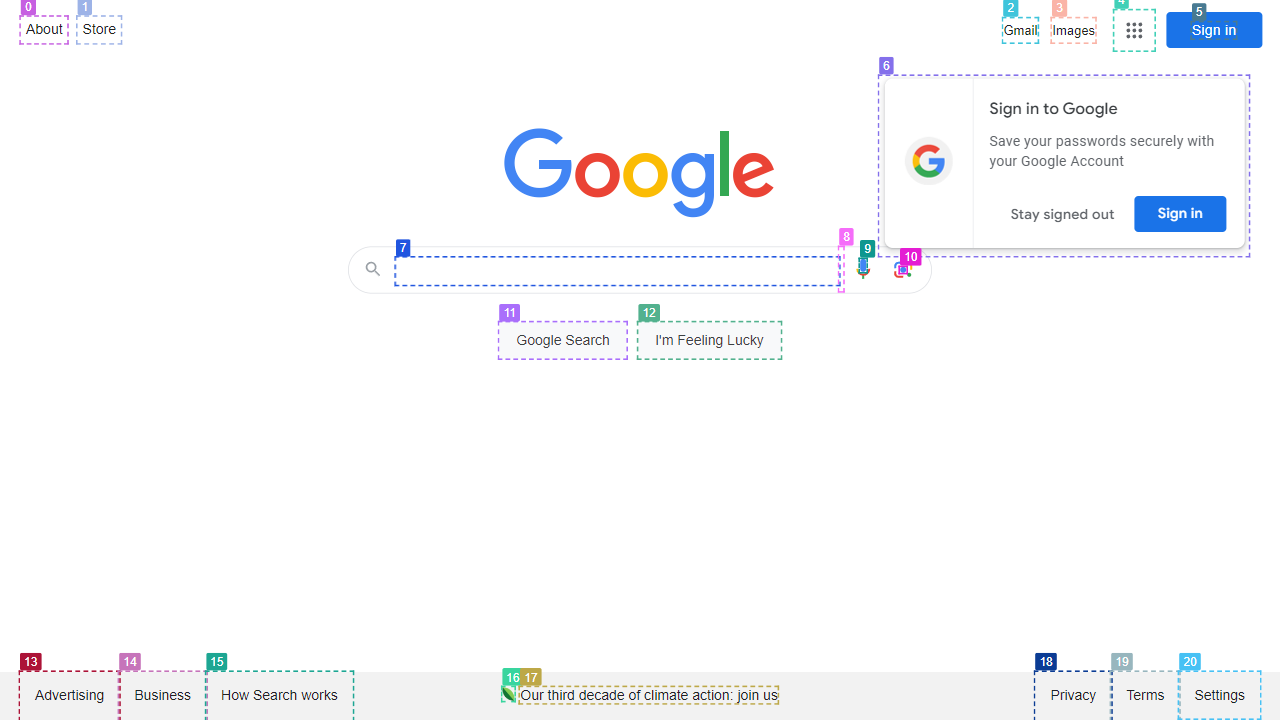

Skipping write for channel Google;:inbox which has no readers


Final response: None


In [164]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page, gemini_graph)
print(f"Final response: {res}")

In [165]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# Headless=False will allows us to see the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

async def call_agent(question: str, page, graph, max_steps: int = 150):
  # Create an event stream that will hold page, input
  event_stream = graph.astream(
      {
          "page": page,
          "input": question,
          "scratchpad": [],
      },
      {
          "recursion_limit": max_steps,
      },
  )
  final_answer = None
  steps = []

  async for event in event_stream:
    if "agent" not in event:
      continue
    # Get the agent's prediction or set to empty dictionary.
    pred = event["agent"].get("prediction") or {}
    # From this prediction, we'll gather the action and its inputs
    action = pred.get("action")
      
    action_input = pred.get("args")
    display.clear_output(wait=False)
    # Add the action and its inputs as a numbered list item casted as a string
    # to steps.
    steps.append(f"{len(steps) + 1}. {action}: {action_input}")
    # Print out the steps taken, and display the image of those actions.
    print("\n".join(steps))
    display.display(display.Image(base64.b64decode(event["agent"]["img"])))
    # Once reaching the end condition set and return the final answer.
    if "ANSWER" in action:
      final_answer = action_input[0]
      break
  return final_answer

1. Type: ['7', 'WebVoyager paper arxiv']
2. Click: ['1']
3. Click: ['13']
4. ANSWER;: ['The "WebVoyager" paper discusses the creation of an advanced web agent called WebVoyager, which is powered by a Large Multimodal Model (LMM) and is designed to handle web tasks end-to-end by interacting with real-world websites. The paper highlights the gap in existing web agents, which typically handle only one input modality and are tested in limited scenarios. WebVoyager aims to address these limitations by being able to complete user instructions using a more robust evaluation protocol that includes automatic evaluation of open-ended web agent tasks. This is achieved by leveraging the capabilities of GPT-4V. The paper claims that WebVoyager significantly outperforms both GPT-4 and a text-only version of the WebVoyager in practical applications, boasting a 55.7% task success rate. The research introduces a new benchmark by gathering real-world tasks from 15 widely used websites to evaluate their 

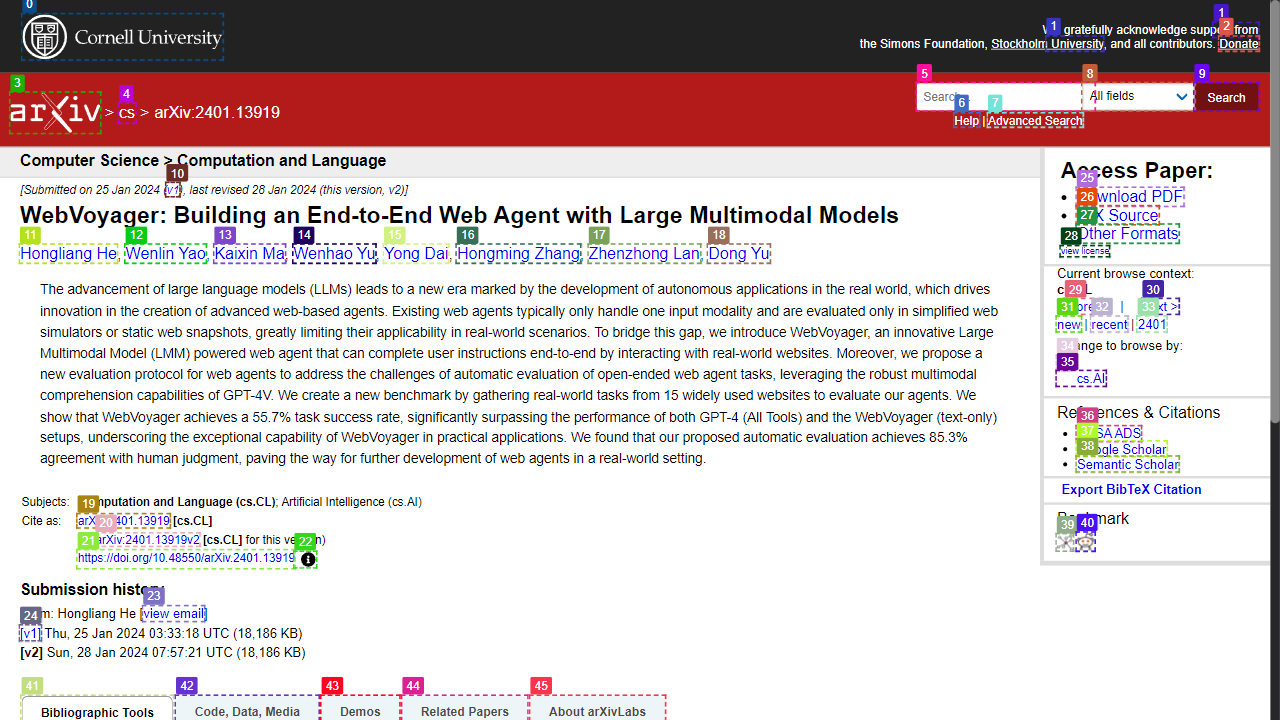

Final response: The "WebVoyager" paper discusses the creation of an advanced web agent called WebVoyager, which is powered by a Large Multimodal Model (LMM) and is designed to handle web tasks end-to-end by interacting with real-world websites. The paper highlights the gap in existing web agents, which typically handle only one input modality and are tested in limited scenarios. WebVoyager aims to address these limitations by being able to complete user instructions using a more robust evaluation protocol that includes automatic evaluation of open-ended web agent tasks. This is achieved by leveraging the capabilities of GPT-4V. The paper claims that WebVoyager significantly outperforms both GPT-4 and a text-only version of the WebVoyager in practical applications, boasting a 55.7% task success rate. The research introduces a new benchmark by gathering real-world tasks from 15 widely used websites to evaluate their agents. The paper suggests that their proposed automatic evaluation meth

In [166]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page, gpt4_graph)
print(f"Final response: {res}")